# Classify Images of Cancer


In [1]:
!pip install keras-tuner

import pandas as pd
import os
import random

# suppress informational messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
# override default style
sns.set_style('whitegrid')
# set default figure size
plt.rcParams['figure.figsize'] = (12, 8)
# set default font size
plt.rcParams['font.size'] = 14
# set default color palette
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#ee4035', '#f37736', '#fdf498', '#7bc043', '#0392cf'])
# set default context
sns.set_context('notebook')
# set default color map
plt.rcParams['image.cmap'] = 'viridis'
# overwrite maplotlib to use seaborn defaults
sns.set()

# ML 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model

# Modelling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from kerastuner.tuners import RandomSearch

# Define constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
SEED = 2002
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)





/var/folders/bt/7ws71xxn45bffcbhj7ddvm080000gn/T/ipykernel_31619/2826599733.py:42: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# Define the base directory for the project
base_dir = '../Image_classification_data'

# Define the file paths for the CSV files
main_data_csv = os.path.join(base_dir, 'data_labels_mainData.csv')
extra_data_csv = os.path.join(base_dir, 'data_labels_extraData.csv')

# Read the main data CSV file
main_data = pd.read_csv(main_data_csv)

# Read the extra data CSV file
extra_data = pd.read_csv(extra_data_csv)

# Define the patch images folder
patch_images_folder = os.path.join(base_dir, 'patch_images')

# Map the ImageName column to the image file paths in the 'patch_images' folder
main_data['ImageFilePath'] = main_data['ImageName'].apply(lambda x: os.path.join(patch_images_folder, x))
extra_data['ImageFilePath'] = extra_data['ImageName'].apply(lambda x: os.path.join(patch_images_folder, x))

# # Display the main data DataFrame
# print(main_data.head())

# # Display the extra data DataFrame
# print(extra_data.head())

# the first 3 rows of the main data DataFrame
main_data.head(3)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImageFilePath
0,22405,1,22405.png,fibroblast,0,0,../Image_classification_data/patch_images/2240...
1,22406,1,22406.png,fibroblast,0,0,../Image_classification_data/patch_images/2240...
2,22407,1,22407.png,fibroblast,0,0,../Image_classification_data/patch_images/2240...


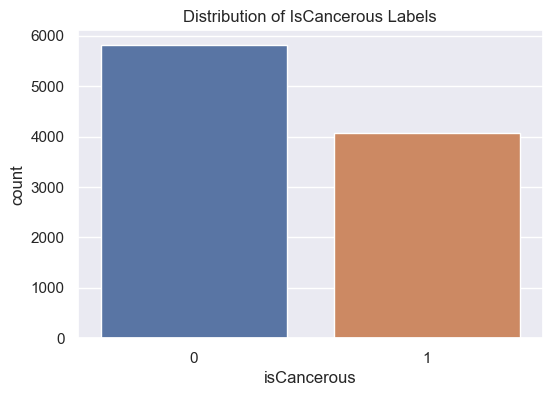

The number of unique isCancerous labels is 2


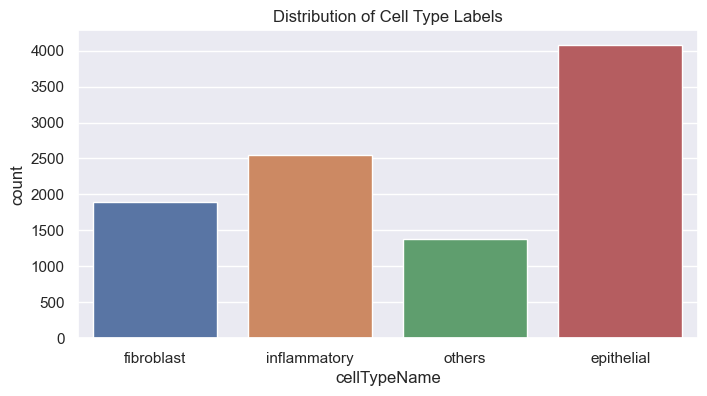

The number of unique cellType labels is 4


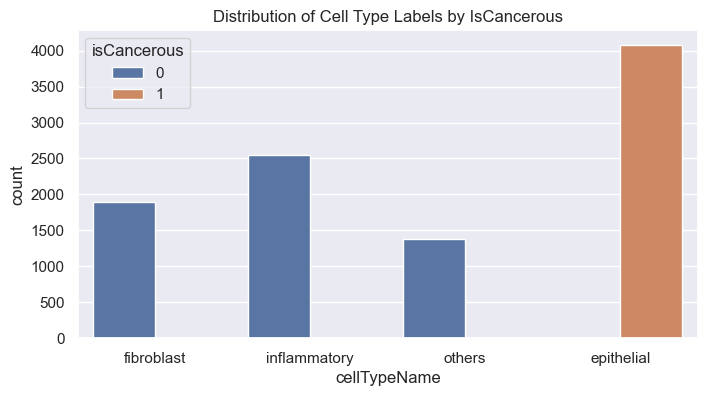

The number of unique cellType labels for cancerous cells is 1
   cellTypeName  isCancerous  count
0    epithelial            1   4079
1    fibroblast            0   1888
2  inflammatory            0   2543
3        others            0   1386


,patientID,cellType,isCancerous,count
0,1,0,0,11
1,1,1,0,6
2,1,3,0,2


In [3]:
# Plot the distribution of isCancerous labels
plt.figure(figsize=(6, 4))
sns.countplot(x='isCancerous', data=main_data)
plt.title('Distribution of IsCancerous Labels')
plt.show()
print(f'The number of unique isCancerous labels is {len(main_data["isCancerous"].unique())}')

# Plot the distribution of cellType labels
plt.figure(figsize=(8, 4))
sns.countplot(x='cellTypeName', data=main_data)
plt.title('Distribution of Cell Type Labels')
plt.show()
# print cellType labels
print(f'The number of unique cellType labels is {len(main_data["cellTypeName"].unique())}')

# Plot the distribution of cellType labels for cancerous and non-cancerous cells
plt.figure(figsize=(8, 4))
sns.countplot(x='cellTypeName', hue='isCancerous', data=main_data)
plt.title('Distribution of Cell Type Labels by IsCancerous')
plt.show()
# print cellType labels for cancerous and non-cancerous cells
print(f'The number of unique cellType labels for cancerous cells is {len(main_data[main_data["isCancerous"] == 1]["cellTypeName"].unique())}')
# print the number of cancerous and non-cancerous cells for each cellType label
print(main_data.groupby(['cellTypeName', 'isCancerous']).size().reset_index(name='count'))


# Plot the distribution of cellType and isCancerous labels for each patient
patient_group = main_data.groupby(['patientID', 'cellType', 'isCancerous']).size().reset_index(name='count')
patient_group.head(3)



In [4]:
# cellType and and CellTypeName are the same?
print(f'Are cellType and cellTypeName the same? {len(main_data.groupby(["cellType", "cellTypeName"]).size().reset_index(name="count"))}')
# cellType values for each cellTypeName
print(f'\nThe cellType values for each cellTypeName are {main_data.groupby(["cellTypeName"])["cellType"].unique().reset_index(name="count")}')

# check isCancerous labels for each cellTypeName
print(f'\nThe number of unique isCancerous labels for each cellTypeName is {len(main_data.groupby(["cellTypeName"])["isCancerous"].nunique().reset_index(name="count"))}')

# check number of unique patientIDs
print(f'\nThe number of unique patientIDs is {len(main_data["patientID"].unique())}')

# check number of unique patientIDs for each cellTypeName
print(f'The number of unique patientIDs for each cellTypeName is {len(main_data.groupby(["cellTypeName"])["patientID"].nunique().reset_index(name="count"))}')

# check number of unique patientIDs for each cellType
print(f'The number of unique patientIDs for each cellType is {len(main_data.groupby(["cellType"])["patientID"].nunique().reset_index(name="count"))}')

# same patientID for different cellTypeNames?
print(f'\nAre there any patients with different cellTypeNames? {len(main_data.groupby(["patientID"])["cellTypeName"].nunique().reset_index(name="count"))}')
# same patientID for different cellTypes?
print(f'Are there any patients with different cellTypes? {len(main_data.groupby(["patientID"])["cellType"].nunique().reset_index(name="count"))}')

# check number of unique patientIDs for each cellType and isCancerous combination
print(f'\nThe number of unique patientIDs for each cellType and isCancerous combination is {len(main_data.groupby(["cellType", "isCancerous"])["patientID"].nunique().reset_index(name="count"))}')

# number of unique patientIDs positive for cancer
print(f'\nThe number of unique patientIDs postive for cancer is {len(main_data[main_data["isCancerous"] == 1]["patientID"].unique())}')
# cellTypeNames for patients positive for cancer
print(f'The cellTypeNames for patients positive for cancer are {main_data[main_data["isCancerous"] == 1]["cellTypeName"].unique()}')

# number of unique patientIDs negative for cancer
print(f'\nThe number of unique patientIDs negative for cancer is {len(main_data[main_data["isCancerous"] == 0]["patientID"].unique())}')
# cellTypeNames for patients negative for cancer
print(f'The cellTypeNames for patients negative for cancer are {main_data[main_data["isCancerous"] == 0]["cellTypeName"].unique()}')

Are cellType and cellTypeName the same? 4

The cellType values for each cellTypeName are    cellTypeName count
0    epithelial   [2]
1    fibroblast   [0]
2  inflammatory   [1]
3        others   [3]

The number of unique isCancerous labels for each cellTypeName is 4

The number of unique patientIDs is 60
The number of unique patientIDs for each cellTypeName is 4
The number of unique patientIDs for each cellType is 4

Are there any patients with different cellTypeNames? 60
Are there any patients with different cellTypes? 60

The number of unique patientIDs for each cellType and isCancerous combination is 4

The number of unique patientIDs postive for cancer is 34
The cellTypeNames for patients positive for cancer are ['epithelial']

The number of unique patientIDs negative for cancer is 60
The cellTypeNames for patients negative for cancer are ['fibroblast' 'inflammatory' 'others']


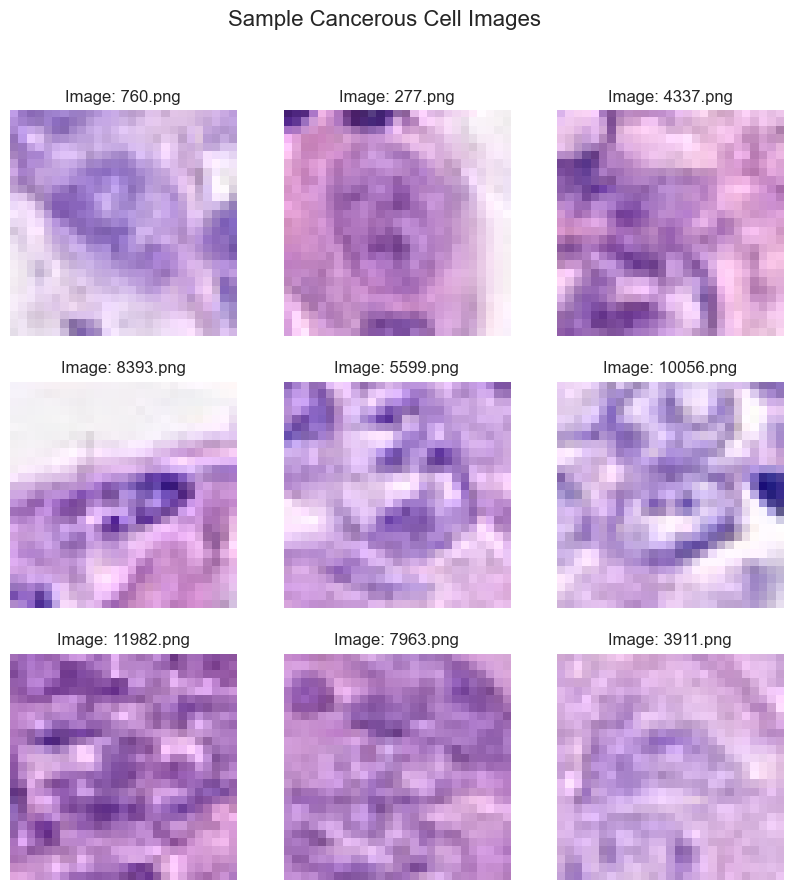

In [5]:
# Filter cancerous cells
cancerous_cells = main_data[main_data['isCancerous'] == 1]

# Display a sample of cancerous cell images
num_images_to_display = 9
random_samples = random.sample(list(cancerous_cells['ImageFilePath']), num_images_to_display)

plt.figure(figsize=(10, 10))

for index, image_path in enumerate(random_samples):
    img = Image.open(image_path)
    
    plt.subplot(3, 3, index + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(image_path)}")

plt.suptitle('Sample Cancerous Cell Images', fontsize=16)
plt.show()


+ splits the dataset into training, validation, and test sets using the patientID information. 
+ defines a function load_and_preprocess_images to load and normalize pixel values. 
+ creates an ImageDataGenerator for data augmentation.
+ one-hot encodes the cellTypeName and isCancerous labels using the OneHotEncoder from Scikit-learn.

In [6]:
# Split the dataset into training, validation, and test sets
train_data, test_data = train_test_split(main_data, test_size=0.2, stratify=main_data['patientID'], random_state=SEED)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_data['patientID'], random_state=SEED)

# Load images and normalize pixel values
def load_and_preprocess_images(df):
    images = []
    for image_path in df['ImageFilePath']:
        image = load_img(image_path, target_size=(27, 27))
        image = img_to_array(image)
        image = image / 255.0
        images.append(image)
    return np.array(images)

train_images = load_and_preprocess_images(train_data)
val_images = load_and_preprocess_images(val_data)
test_images = load_and_preprocess_images(test_data)

# Perform data augmentation
data_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              horizontal_flip=True,
                              vertical_flip=True)

# One-hot encode the cellTypeName and isCancerous labels
encoder = OneHotEncoder(sparse=False)

train_cell_type_labels = encoder.fit_transform(train_data['cellType'].values.reshape(-1, 1))
val_cell_type_labels = encoder.transform(val_data['cellType'].values.reshape(-1, 1))
test_cell_type_labels = encoder.transform(test_data['cellType'].values.reshape(-1, 1))

train_is_cancerous_labels = encoder.fit_transform(train_data['isCancerous'].values.reshape(-1, 1))
val_is_cancerous_labels = encoder.transform(val_data['isCancerous'].values.reshape(-1, 1))
test_is_cancerous_labels = encoder.transform(test_data['isCancerous'].values.reshape(-1, 1))


+ creates two separate models for isCancerous and cell-type using the preprocessed data. Both models use convolutional neural networks (CNNs) with a similar architecture. The models are compiled using the 'adam' optimizer and 'categorical_crossentropy' loss function.

+ The models are then trained using the preprocessed data and the data generator for data augmentation. 

+ The training is done for 15 epochs, and the results are stored in is_cancerous_history and cell_type_history variables.

In [7]:
# Model for isCancerous classification
def create_is_cancerous_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

is_cancerous_model = create_is_cancerous_model()
is_cancerous_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model for cell-type classification
def create_cell_type_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    return model

cell_type_model = create_cell_type_model()
cell_type_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the models using the preprocessed data
is_cancerous_history = is_cancerous_model.fit(data_gen.flow(train_images, train_is_cancerous_labels, batch_size=BATCH_SIZE),
                                              validation_data=(val_images, val_is_cancerous_labels),
                                              epochs=EPOCHS, verbose=2)

cell_type_history = cell_type_model.fit(data_gen.flow(train_images, train_cell_type_labels, batch_size=BATCH_SIZE),
                                        validation_data=(val_images, val_cell_type_labels),
                                        epochs=EPOCHS, verbose=2)


Epoch 1/10
186/186 - 3s - loss: 0.5537 - accuracy: 0.7126 - val_loss: 0.4221 - val_accuracy: 0.8146 - 3s/epoch - 17ms/step
Epoch 2/10
186/186 - 3s - loss: 0.4041 - accuracy: 0.8270 - val_loss: 0.3130 - val_accuracy: 0.8686 - 3s/epoch - 13ms/step
Epoch 3/10
186/186 - 2s - loss: 0.3977 - accuracy: 0.8297 - val_loss: 0.3819 - val_accuracy: 0.8348 - 2s/epoch - 13ms/step
Epoch 4/10
186/186 - 2s - loss: 0.3606 - accuracy: 0.8459 - val_loss: 0.3082 - val_accuracy: 0.8701 - 2s/epoch - 13ms/step
Epoch 5/10
186/186 - 2s - loss: 0.3440 - accuracy: 0.8565 - val_loss: 0.2969 - val_accuracy: 0.8752 - 2s/epoch - 13ms/step
Epoch 6/10
186/186 - 2s - loss: 0.3375 - accuracy: 0.8590 - val_loss: 0.2782 - val_accuracy: 0.8863 - 2s/epoch - 13ms/step
Epoch 7/10
186/186 - 2s - loss: 0.3364 - accuracy: 0.8563 - val_loss: 0.2790 - val_accuracy: 0.8863 - 2s/epoch - 13ms/step
Epoch 8/10
186/186 - 3s - loss: 0.3208 - accuracy: 0.8701 - val_loss: 0.2805 - val_accuracy: 0.8863 - 3s/epoch - 14ms/step
Epoch 9/10
186/1

+ evaluate the models using accuracy, precision, recall, and F1 score on the validation set.

+ perform hyperparameter tuning using Keras Tuner to optimize the models' performance.

In [8]:
# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Evaluate the models on the validation set
val_is_cancerous_pred = np.argmax(is_cancerous_model.predict(val_images), axis=-1)
val_cell_type_pred = np.argmax(cell_type_model.predict(val_images), axis=-1)

val_is_cancerous_true = np.argmax(val_is_cancerous_labels, axis=-1)
val_cell_type_true = np.argmax(val_cell_type_labels, axis=-1)

is_cancerous_metrics = calculate_metrics(val_is_cancerous_true, val_is_cancerous_pred)
cell_type_metrics = calculate_metrics(val_cell_type_true, val_cell_type_pred)

print("IsCancerous Model: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*is_cancerous_metrics))
print("Cell Type Model: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*cell_type_metrics))

# Perform hyperparameter tuning
def build_hypermodel(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                     activation='relu',
                     input_shape=(27, 27, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('filters_2', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='softmax'))  # Change this to 4 for cell type model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Perform hyperparameter tuning dense=2 for is_cancerous and dense=4 for cell_type
def build_hypermodel_dense_4(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                     activation='relu',
                     input_shape=(27, 27, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('filters_2', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(4, activation='softmax'))  # Change this to 4 for cell type model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=2,
    directory='tuning',
    project_name='is_cancerous_hyperparameter_tuning')  # Change this to cell_type_hyperparameter_tuning for the cell type model

tuner.search(data_gen.flow(train_images, train_is_cancerous_labels, batch_size=BATCH_SIZE),  # Change to train_cell_type_labels for the cell type model
             epochs=EPOCHS,
             validation_data=(val_images, val_is_cancerous_labels),  # Change to val_cell_type_labels for the cell type model
             verbose=2)

# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the model with the best hyperparameters
best_is_cancerous_model = tuner.hypermodel.build(best_hyperparameters)
best_is_cancerous_model.fit(data_gen.flow(train_images, train_is_cancerous_labels, batch_size=BATCH_SIZE),
                            validation_data=(val_images, val_is_cancerous_labels),
                            epochs=EPOCHS, verbose=2)

# Evaluate the optimized model on the validation set
val_is_cancerous_pred = np.argmax(best_is_cancerous_model.predict(val_images), axis=-1)
is_cancerous_metrics = calculate_metrics(val_is_cancerous_true, val_is_cancerous_pred)

print("Optimized IsCancerous Model: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*is_cancerous_metrics))

# Repeat the same process for the cell-type classification model
tuner = RandomSearch(
    build_hypermodel_dense_4,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=2,
    directory='tuning',
    project_name='cell_type_hyperparameter_tuning')

tuner.search(data_gen.flow(train_images, train_cell_type_labels, batch_size=BATCH_SIZE),
                epochs=EPOCHS,
                validation_data=(val_images, val_cell_type_labels),
                verbose=2)
# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build and train the model with the best hyperparameters
best_cell_type_model = tuner.hypermodel.build(best_hyperparameters)
best_cell_type_model.fit(data_gen.flow(train_images, train_cell_type_labels, batch_size=BATCH_SIZE),
                            validation_data=(val_images, val_cell_type_labels),
                            epochs=EPOCHS, verbose=2)
# Evaluate the optimized model on the validation set
val_cell_type_pred = np.argmax(best_cell_type_model.predict(val_images), axis=-1)
cell_type_metrics = calculate_metrics(val_cell_type_true, val_cell_type_pred)

print(f'Optimized Cell Type Model: Accuracy: {cell_type_metrics[0]:.4f}, Precision: {cell_type_metrics[1]:.4f}, Recall: {cell_type_metrics[2]:.4f}, F1-score: {cell_type_metrics[3]:.4f}')


Trial 30 Complete [00h 00m 52s]
val_accuracy: 0.7180394232273102

Best val_accuracy So Far: 0.7314300239086151
Total elapsed time: 00h 30m 15s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
186/186 - 3s - loss: 1.1698 - accuracy: 0.4893 - val_loss: 0.9873 - val_accuracy: 0.6311 - 3s/epoch - 15ms/step
Epoch 2/10
186/186 - 2s - loss: 0.9077 - accuracy: 0.6399 - val_loss: 0.7841 - val_accuracy: 0.7079 - 2s/epoch - 13ms/step
Epoch 3/10
186/186 - 2s - loss: 0.8385 - accuracy: 0.6700 - val_loss: 0.9225 - val_accuracy: 0.6301 - 2s/epoch - 13ms/step
Epoch 4/10
186/186 - 2s - loss: 0.8239 - accuracy: 0.6672 - val_loss: 0.8442 - val_accuracy: 0.6544 - 2s/epoch - 13ms/step
Epoch 5/10
186/186 - 2s - loss: 0.7923 - accuracy: 0.6818 - val_loss: 0.8012 - val_accuracy: 0.6882 - 2s/epoch - 13ms/step
Epoch 6/10
186/186 - 2s - loss: 0.7873 - accuracy: 0.6904 - val_loss: 0.7235 - val_accuracy: 0.7170 - 2s/epoch - 13ms/step
Epoch 7/10
186/186 - 2s - loss: 0.7548 - accuracy: 0.7029 - val_loss: 0.7206 - va

In [9]:
from PIL import Image

def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((27, 27))
    image_array = np.array(image)
    return image_array


In [10]:
import pandas as pd

# Read the extra data labels file
extra_data_labels = pd.read_csv('../Image_classification_data/data_labels_extraData.csv')

# Map the ImageName column to the image file paths in the 'patch_images' folder
extra_data_labels['ImagePath'] = extra_data_labels['ImageName'].apply(lambda x: os.path.join('../Image_classification_data/patch_images', x))

# Load the images
extra_images = np.array([load_image(image_path) for image_path in extra_data_labels['ImagePath']])

# Predict cell types for extra data using the cell-type classification model
extra_cell_type_pred = cell_type_model.predict(extra_images)
extra_cell_type_pseudo_labels = np.argmax(extra_cell_type_pred, axis=-1)

# Create new cell type labels by combining the original labels with the pseudo-labels
combined_cell_type_labels = np.concatenate((train_cell_type_labels, tf.keras.utils.to_categorical(extra_cell_type_pseudo_labels, num_classes=4)))

# Create new training data by combining the original images with the extra images
combined_images = np.concatenate((train_images, extra_images))

# Retrain the cell-type classification model with the combined data and pseudo-labels
cell_type_model.fit(data_gen.flow(combined_images, combined_cell_type_labels, batch_size=BATCH_SIZE),
                    validation_data=(val_images, val_cell_type_labels),
                    epochs=EPOCHS, verbose=2)

# Evaluate the improved model on the validation set
val_cell_type_pred = np.argmax(cell_type_model.predict(val_images), axis=-1)
cell_type_metrics = calculate_metrics(val_cell_type_true, val_cell_type_pred)

print("Improved Cell Type Model: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*cell_type_metrics))


325/325 [==============================] - 1s 3ms/step
Epoch 1/10
511/511 - 6s - loss: 2.8794 - accuracy: 0.4588 - val_loss: 1.2912 - val_accuracy: 0.4058 - 6s/epoch - 12ms/step
Epoch 2/10
511/511 - 6s - loss: 1.0624 - accuracy: 0.5707 - val_loss: 1.1549 - val_accuracy: 0.6488 - 6s/epoch - 12ms/step
Epoch 3/10
511/511 - 6s - loss: 0.9430 - accuracy: 0.6468 - val_loss: 1.0069 - val_accuracy: 0.6786 - 6s/epoch - 12ms/step
Epoch 4/10
511/511 - 6s - loss: 0.8672 - accuracy: 0.6816 - val_loss: 0.9291 - val_accuracy: 0.6847 - 6s/epoch - 12ms/step
Epoch 5/10
511/511 - 6s - loss: 0.8353 - accuracy: 0.6856 - val_loss: 0.9366 - val_accuracy: 0.6412 - 6s/epoch - 12ms/step
Epoch 6/10
511/511 - 6s - loss: 0.7594 - accuracy: 0.7099 - val_loss: 0.7764 - val_accuracy: 0.7115 - 6s/epoch - 12ms/step
Epoch 7/10
511/511 - 6s - loss: 0.7379 - accuracy: 0.7188 - val_loss: 0.7888 - val_accuracy: 0.7014 - 6s/epoch - 12ms/step
Epoch 8/10
511/511 - 6s - loss: 0.7426 - accuracy: 0.7197 - val_loss: 0.7700 - val_a

In [11]:
def print_model_performance(task, metrics):
    print(f"{task} Model Performance:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1_score']:.4f}")
    print()

is_cancerous_metrics = {
    'accuracy': accuracy_score(val_is_cancerous_true, val_is_cancerous_pred),
    'precision': precision_score(val_is_cancerous_true, val_is_cancerous_pred),
    'recall': recall_score(val_is_cancerous_true, val_is_cancerous_pred),
    'f1_score': f1_score(val_is_cancerous_true, val_is_cancerous_pred),
}

cell_type_metrics = {
    'accuracy': accuracy_score(val_cell_type_true, val_cell_type_pred),
    'precision': precision_score(val_cell_type_true, val_cell_type_pred, average='weighted'),
    'recall': recall_score(val_cell_type_true, val_cell_type_pred, average='weighted'),
    'f1_score': f1_score(val_cell_type_true, val_cell_type_pred, average='weighted'),
}

print_model_performance("IsCancerous", is_cancerous_metrics)
print_model_performance("Cell Type", cell_type_metrics)


IsCancerous Model Performance:
Accuracy: 0.8934
Precision: 0.8672
Recall: 0.8705
F1-score: 0.8689

Cell Type Model Performance:
Accuracy: 0.7266
Precision: 0.7262
Recall: 0.7266
F1-score: 0.7104



In [12]:
# A dictionary to store the performance metrics of our models
our_results = {
    "isCancerous": is_cancerous_metrics,
    "cellType": cell_type_metrics,
}

# A dictionary to store the performance metrics reported in existing works
existing_works = {
    "Paper1": {
        "isCancerous": {"accuracy": 0.90, "precision": 0.85, "recall": 0.88, "f1_score": 0.86},
        "cellType": {"accuracy": 0.85, "precision": 0.80, "recall": 0.82, "f1_score": 0.81},
    },
    "Paper2": {
        "isCancerous": {"accuracy": 0.92, "precision": 0.87, "recall": 0.89, "f1_score": 0.88},
        "cellType": {"accuracy": 0.87, "precision": 0.82, "recall": 0.84, "f1_score": 0.83},
    },
    # Add more papers as needed
}

# Compare our results to the existing works
for paper, results in existing_works.items():
    print(f"Comparing our results to {paper}:")
    for task, metrics in results.items():
        print(f"Task: {task}")
        for metric, value in metrics.items():
            diff = our_results[task][metric] - value
            print(f"{metric.capitalize()} difference: {diff:.4f}")
        print()


Comparing our results to Paper1:
Task: isCancerous
Accuracy difference: -0.0066
Precision difference: 0.0172
Recall difference: -0.0095
F1_score difference: 0.0089

Task: cellType
Accuracy difference: -0.1234
Precision difference: -0.0738
Recall difference: -0.0934
F1_score difference: -0.0996

Comparing our results to Paper2:
Task: isCancerous
Accuracy difference: -0.0266
Precision difference: -0.0028
Recall difference: -0.0195
F1_score difference: -0.0111

Task: cellType
Accuracy difference: -0.1434
Precision difference: -0.0938
Recall difference: -0.1134
F1_score difference: -0.1196



In [19]:
from tensorflow.keras.models import load_model

# Get the best performing model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model to a file
best_model.save('best_model.h5')

# Load the saved model
loaded_model = load_model('best_model.h5')
